# Google Capstone Project: Cyclistic

Cyclistic, a bike-share company in Chicago wants to discover how annual member riders differ from casual riders. They have concluded that annual members are much more profitable than casual riders and they want to discover ways to convert casual rides to members.  


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from matplotlib import cm
from matplotlib import cycler
import folium
from folium import plugins
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline

Data are downloaded from this [link](https://divvy-tripdata.s3.amazonaws.com/index.html). We downloaded all the files from 2013, July to 2021, Dec by using SSIS and SSMS pachages. Data are prepared and cleaned in SQL (SQL codes are available [here](SQL/SQLQuery.sql))

In [3]:
data = pd.read_csv('C:\\Users\\hamed\\OneDrive - The University Of British Columbia\\Desktop\\Today\\Google Capstone\\Data\\bike_share_2013_2020_v02_main.csv',low_memory=False)

In [4]:
# making usre that all rows are imported
data.info() 
############# all 29004527 rows are imported

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29004528 entries, 0 to 29004527
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_id            object 
 1   bike_type          object 
 2   startdate          object 
 3   stopdate           object 
 4   starttime          object 
 5   stoptime           object 
 6   tripduration_sec   int64  
 7   from_station_name  object 
 8   to_station_name    object 
 9   from_lat           float64
 10  from_lng           float64
 11  to_lat             float64
 12  to_lng             float64
 13  membership         object 
 14  gender             object 
 15  birthday_year      float64
 16  startday           object 
 17  stopday            object 
 18  age                float64
dtypes: float64(6), int64(1), object(12)
memory usage: 4.1+ GB


In [5]:
data.head()

,trip_id,bike_type,startdate,stopdate,starttime,stoptime,tripduration_sec,from_station_name,to_station_name,from_lat,from_lng,to_lat,to_lng,membership,gender,birthday_year,startday,stopday,age
0,1786735,classic_bike,2014-05-24,2014-05-24,12:36:00.0000000,12:49:00.0000000,764,Clinton St & Madison St,Sangamon St & Washington Blvd,41.88,-87.64,41.88,-87.64,casual,Male,1975.0,Saturday,Saturday,39.0
1,1786734,classic_bike,2014-05-24,2014-05-24,12:36:00.0000000,13:00:00.0000000,1406,Lake Shore Dr & Ohio St,Theater on the Lake,41.89,-87.61,41.90,-87.63,casual,Male,1982.0,Saturday,Saturday,32.0
2,1786733,classic_bike,2014-05-24,2014-05-24,12:36:00.0000000,13:05:00.0000000,1739,Streeter Dr & Illinois St,Lake Shore Dr & North Blvd,41.89,-87.61,41.89,-87.62,member,NaN,NaN,Saturday,Saturday,NaN
3,1786732,classic_bike,2014-05-24,2014-05-24,12:36:00.0000000,12:54:00.0000000,1064,McClurg Ct & Illinois St,Millennium Park,41.89,-87.62,41.89,-87.63,member,NaN,NaN,Saturday,Saturday,NaN
4,1786731,classic_bike,2014-05-24,2014-05-24,12:36:00.0000000,12:54:00.0000000,1086,Pine Grove Ave & Irving Park Rd,Lake Shore Dr & Belmont Ave,41.95,-87.65,41.94,-87.65,member,NaN,NaN,Saturday,Saturday,NaN


We add one more row to the data that indicates the day that each rides starts/ends. 

In [6]:
#adding a column in the data that indicates the day in each date. 
data ['startday'] = data['startdate'].apply(lambda x: pd.Timestamp(x).day_name())
data ['stopday'] = data['stopdate'].apply(lambda x: pd.Timestamp(x).day_name())
data.loc[:,'age'] = pd.DatetimeIndex(data['startdate']).year-data['birthday_year']
data = data [(data ['membership'] == 'casual') | (data ['membership'] == 'member')]

This cell is primary for reducing the size of data in Tabluea. Tableau public does not allow data more than 15,000,000 rows and we needed to decrease the number of rows. We decreased the number of rows so that it does not affect the time period for the data. 

In [ ]:
data_viz = data.sort_values('startdate').iloc[1:29004718:4]

In [ ]:
data_viz.to_csv('C:\\Users\\hamed\\OneDrive - The University Of British Columbia\\Desktop\\Today\\Google Capstone\\Data\\bike_share_2013_2020_v02_viz.csv', index = False)

In [7]:
# splitting the data into two: memebr riders and causual riders
data_m = data [data['membership'] == 'member']
data_c = data [data['membership'] == 'casual']

### Number of members and casual riders over time
First, we plot the trend of causual riders and memebr riders over time. We change the format for starttime to date and then convert it to quarters. Fianlly, group the data by quarters and add aliasing to quarter (showing seasons instead of quarters) 

In [8]:
data_m.loc[:,'startdate']=data_m['startdate'].apply(lambda x: pd.Timestamp(x))
data_c.loc[:,'startdate']=data_c['startdate'].apply(lambda x: pd.Timestamp(x))

startdate_count_m=data_m[data_m['startdate']<'2021-09-01']['startdate'].value_counts().rename_axis('startdate').reset_index(name='counts')
startdate_count_m['counts']=startdate_count_m['counts']
#converting date to quarter and yaer
startdate_count_m.loc[:,'startdate'] = \
pd.to_datetime(startdate_count_m["startdate"], dayfirst=True).dt.to_period('Q').dt.strftime('%Yq%q')
startdate_count_m['startdate']=startdate_count_m['startdate'].apply(lambda x:x.upper())


#grouping by qaurter
startdate_count_m=\
startdate_count_m.groupby('startdate').sum().reset_index()


startdate_count_c=data_c[data_c['startdate']<'2021-09-01']['startdate'].value_counts().rename_axis('startdate').reset_index(name='counts')
startdate_count_c['counts']=startdate_count_c['counts']
#converting date to quarter and yaer
startdate_count_c.loc[:,'startdate'] = \
pd.to_datetime(startdate_count_c["startdate"], dayfirst=True).dt.to_period('Q').dt.strftime('%Yq%q')
startdate_count_c['startdate']=startdate_count_c['startdate'].apply(lambda x:x.upper())


#grouping by quarter
startdate_count_c=\
startdate_count_c.groupby('startdate').sum().reset_index()

C:\Users\hamed\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
def quarter_2_season (x1):

    X = x1[0:4]
    if (x1[5]=='1'):
        X = X + ' ' + 'Winter'
    elif (x1[5]=='2'):
        X = X + ' ' + 'Spring'
    elif (x1[5]=='3'):
        X = X + ' ' + 'Summer'    
    elif (x1[5]=='4'):
        X = X + ' ' + 'Fall'     
    return X

startdate_count_m['startdate_season']=startdate_count_m['startdate'].apply(lambda x:quarter_2_season(x))
startdate_count_c['startdate_season']=startdate_count_c['startdate'].apply(lambda x:quarter_2_season(x))

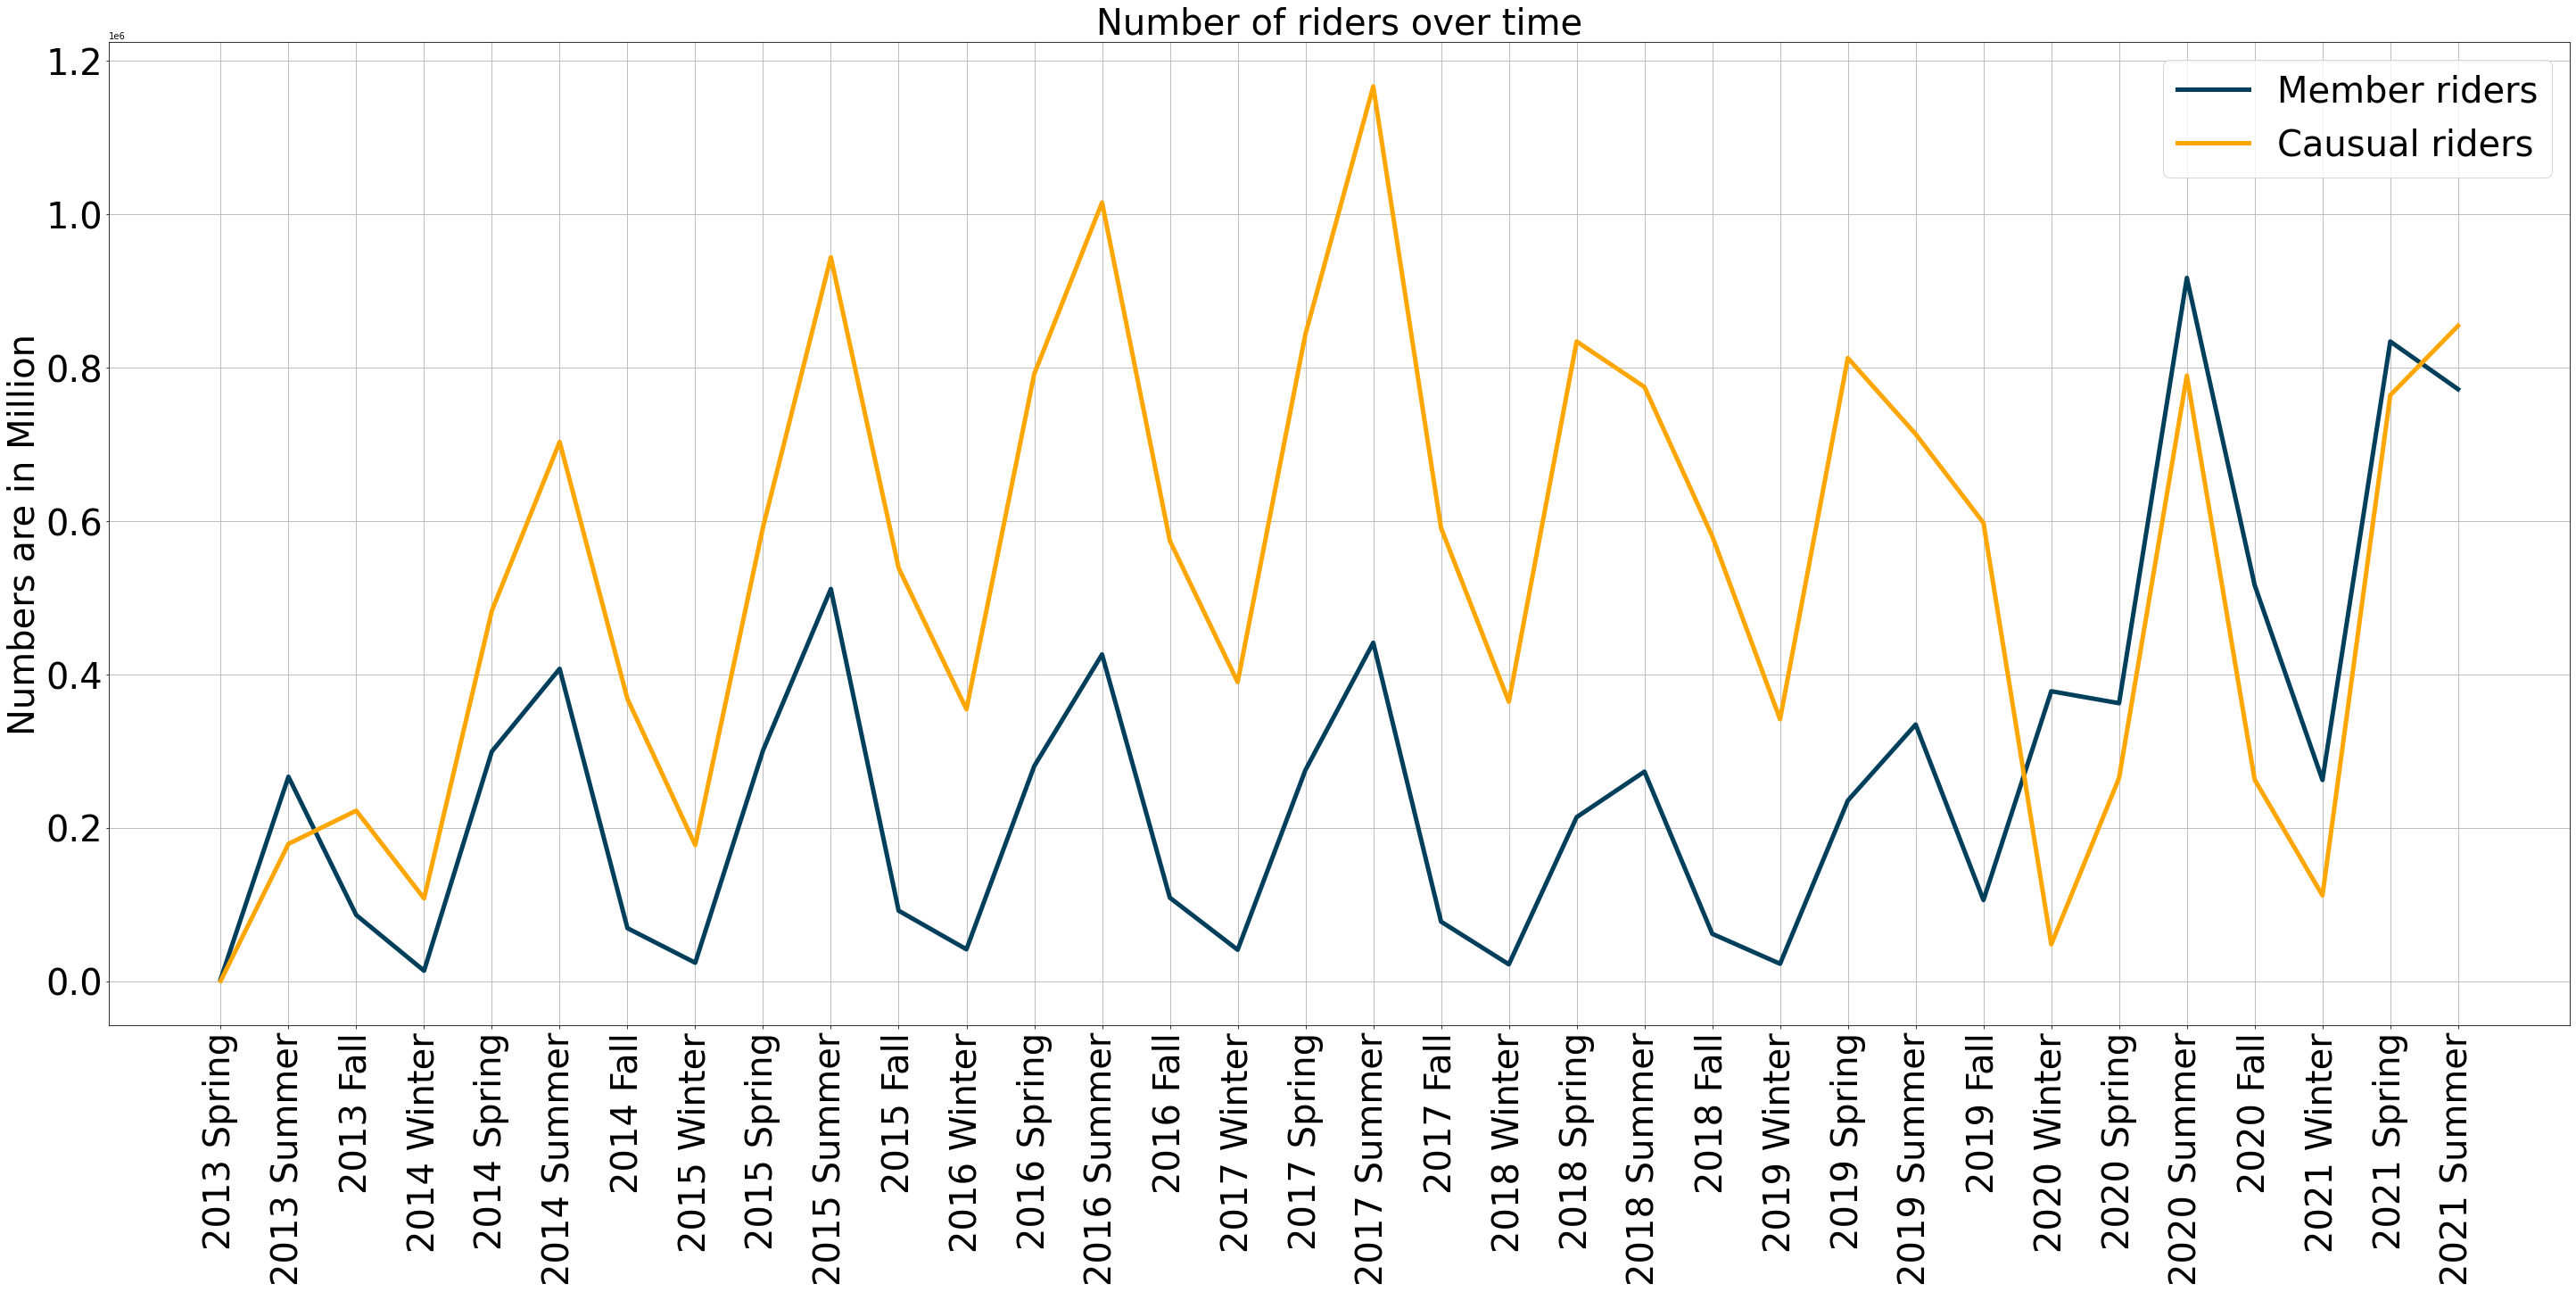

In [10]:
fig, ax = plt.subplots(figsize=(40, 20), constrained_layout=True)
cs = ['#003f5c', '#bc5090', '#ffa600']
ax.plot ('startdate_season', 'counts' , data = \
         startdate_count_m.sort_values('startdate'),color = cs[0],linewidth=5)
ax.plot ('startdate_season', 'counts' , data = \
         startdate_count_c.sort_values('startdate'),color = cs[2],linewidth=5)
ax.legend(['Member riders','Causual riders'],fontsize=40)
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel('Numbers are in Million',fontsize= 40);
plt.xticks(rotation=90,fontsize= 40);
plt.yticks(fontsize= 40);
ax.set_title('Number of riders over time',fontsize= 40);

**The results show that there is a spike in the number of members when Covid started**
* This observation indicates that memebrs are using bikes more for leisure activities. 

### Number of members and casual riders over the days of a week

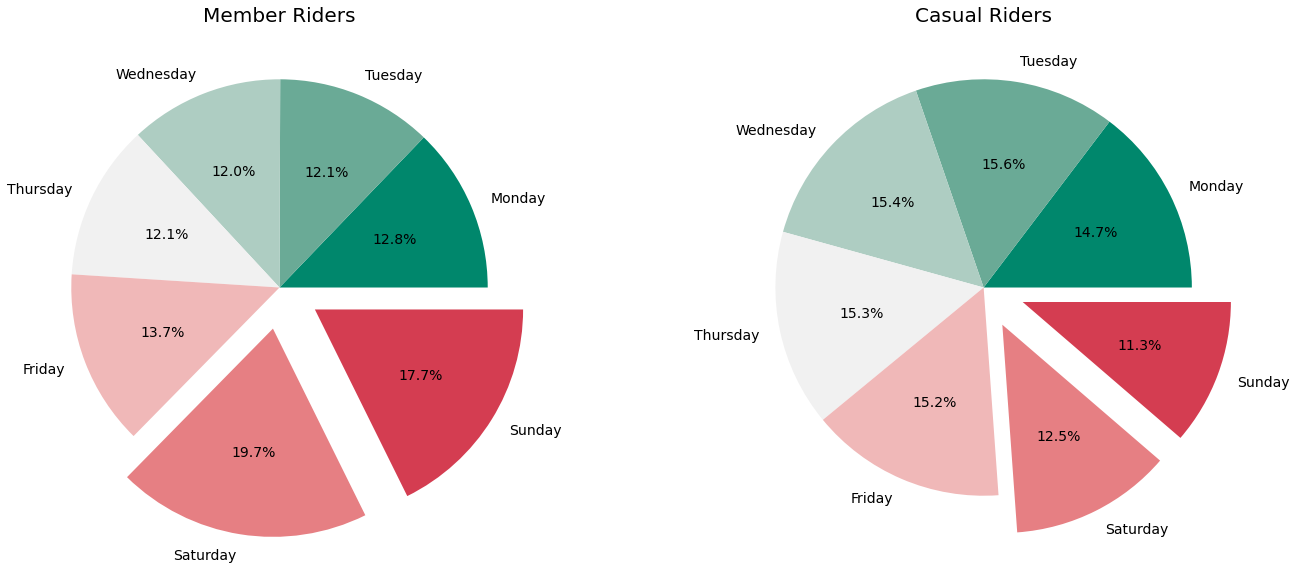

In [11]:
fig1, ax1 = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
cs=["#00876c", "#6aaa96", '#aecdc2', "#f1f1f1", "#f0b8b8", "#e67f83", "#d43d51"]
#https://learnui.design/tools/data-color-picker.html
labels = ["Monday",     "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
explodes = [0,0,0,0,0,0.2,0.2]
data_m.groupby("startday")["trip_id"].count().reindex(labels).\
plot.pie(autopct='%1.1f%%',ax=ax1[0],textprops={'fontsize': 14},colors = cs, explode = explodes)
data_c.groupby("startday")["trip_id"].count().reindex(labels).\
plot.pie(autopct='%1.1f%%',ax=ax1[1],textprops={'fontsize': 14},colors = cs, explode = explodes)
ax1[0].set_ylabel('')
ax1[0].set_title('Member Riders', fontsize=20)
ax1[1].set_ylabel('')
ax1[1].set_title('Casual Riders', fontsize=20)
plt.tight_layout()
# While memebrs usage is maximum during the weekends, causual riders use bikes more in weekdays 
# That can come from the fact that causual members use the cars more for commuting to the work while memebrs use bikes 
# for leisure

**The results show that members are more active during the weekends while causual riders are more during the weekdays**
* This indicates that casual riders are using bikes more for daily commuting to work

### Trip duration for members and casual riders

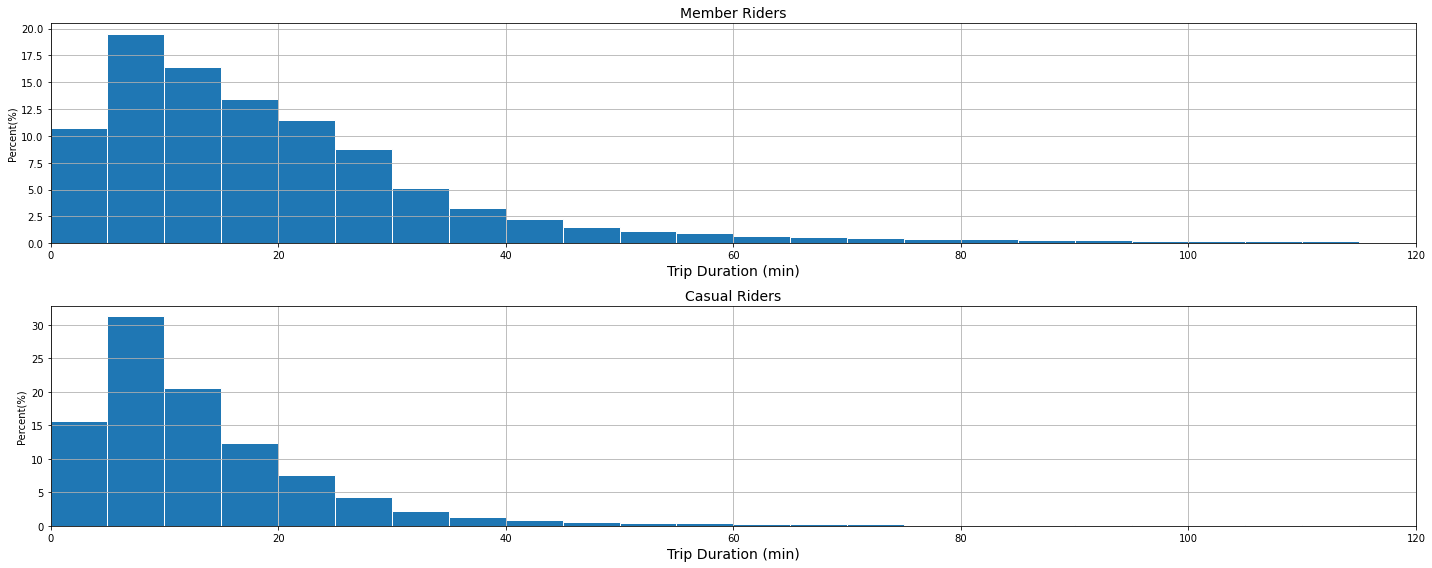

In [12]:
plt.style.context('fivethirtyeight')
fig1, ax1 = plt.subplots(nrows=2,ncols=1, figsize=(20,8))

w = 5
n_m = math.ceil((((data_m['tripduration_sec']/60).max())-((data_m['tripduration_sec']/60).min()))/w)
n_c = math.ceil((((data_c['tripduration_sec']/60).max())-((data_c['tripduration_sec']/60).min()))/w)


(data_m['tripduration_sec']/60).hist(ax = ax1[0],bins=n_m, edgecolor='white',\
                                             weights=np.ones(len(data_m))*100 / len(data_m))
ax1[0].set_xlim([0, 120])
(data_c['tripduration_sec']/60).hist(ax = ax1[1],bins=n_c, edgecolor='white',\
                                            weights=np.ones(len(data_c))*100 / len(data_c))

ax1[1].set_xlim([0, 120])
ax1[0].set_xlabel('Trip Duration (min)', fontsize = 14)
ax1[0].set_ylabel('Percent(%)')
ax1[0].set_title('Member Riders', fontsize=14)
ax1[1].set_xlabel('Trip Duration (min)', fontsize = 14)
ax1[1].set_title('Casual Riders', fontsize=14)
ax1[1].set_ylabel('Percent(%)')
fig1.tight_layout()
plt.show()
# While memebrs usage is maximum during the weekends, causual riders use bikes more in weekdays 
# That can come from the fact that causual members use the cars more for commuting to the work while memebrs use bikes 
# for leisure

**Memebrs are using bikes for longer trip duration than casual riders**
* This again confirms our hypothesis that memebrs are using bikes for outdoor activities and casual riders are using the bikes for daily communting


### Common stations for members and casual riders

In [13]:
from_count_m = data_m ['from_station_name'].dropna().value_counts().rename_axis('from_station_name').to_frame('counts')
from_count_lat_lng_m=pd.merge(from_count_m,data_m,left_on='from_station_name',right_on = 'from_station_name', how = 'left')[['from_station_name','from_lat','from_lng','counts']]

from_count_lat_lng_m.drop_duplicates(inplace=True)



from_count_c =  data_c['from_station_name'].dropna().value_counts().rename_axis('from_station_name').to_frame('counts')
from_count_lat_lng_c=pd.merge(from_count_c,data_c,left_on='from_station_name',right_on = 'from_station_name', how = 'left')[['from_station_name','from_lat','from_lng','counts']]

from_count_lat_lng_c.drop_duplicates(inplace=True)



In [14]:
#https://alysivji.github.io/getting-started-with-folium.html
def map_points(df, lat_col='from_lat', lon_col='from_lng', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['from_station_name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].values
        curr_map.add_child(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [15]:
map_points(from_count_lat_lng_m.dropna(), \
           plot_points=False, draw_heatmap=True,
           heat_map_weights_normalize=False, heat_map_weights_col='counts', heat_map_radius=15)
# This plot is for memebrs

In [16]:
map_points(from_count_lat_lng_c.dropna(), plot_points=False, draw_heatmap=True,
           heat_map_weights_normalize=False, heat_map_weights_col='counts', heat_map_radius=15)
#this plot is for causual riders

**Heat maps for the station locations demonstrate that the memebrs are using stations that are close to Chicago's attraction, especially those near Mishigan Lake. While, the common stations for causual riders are distributed along the city**

### Finally, we check the age distribution of memebrs and causual riders

C:\Users\hamed\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


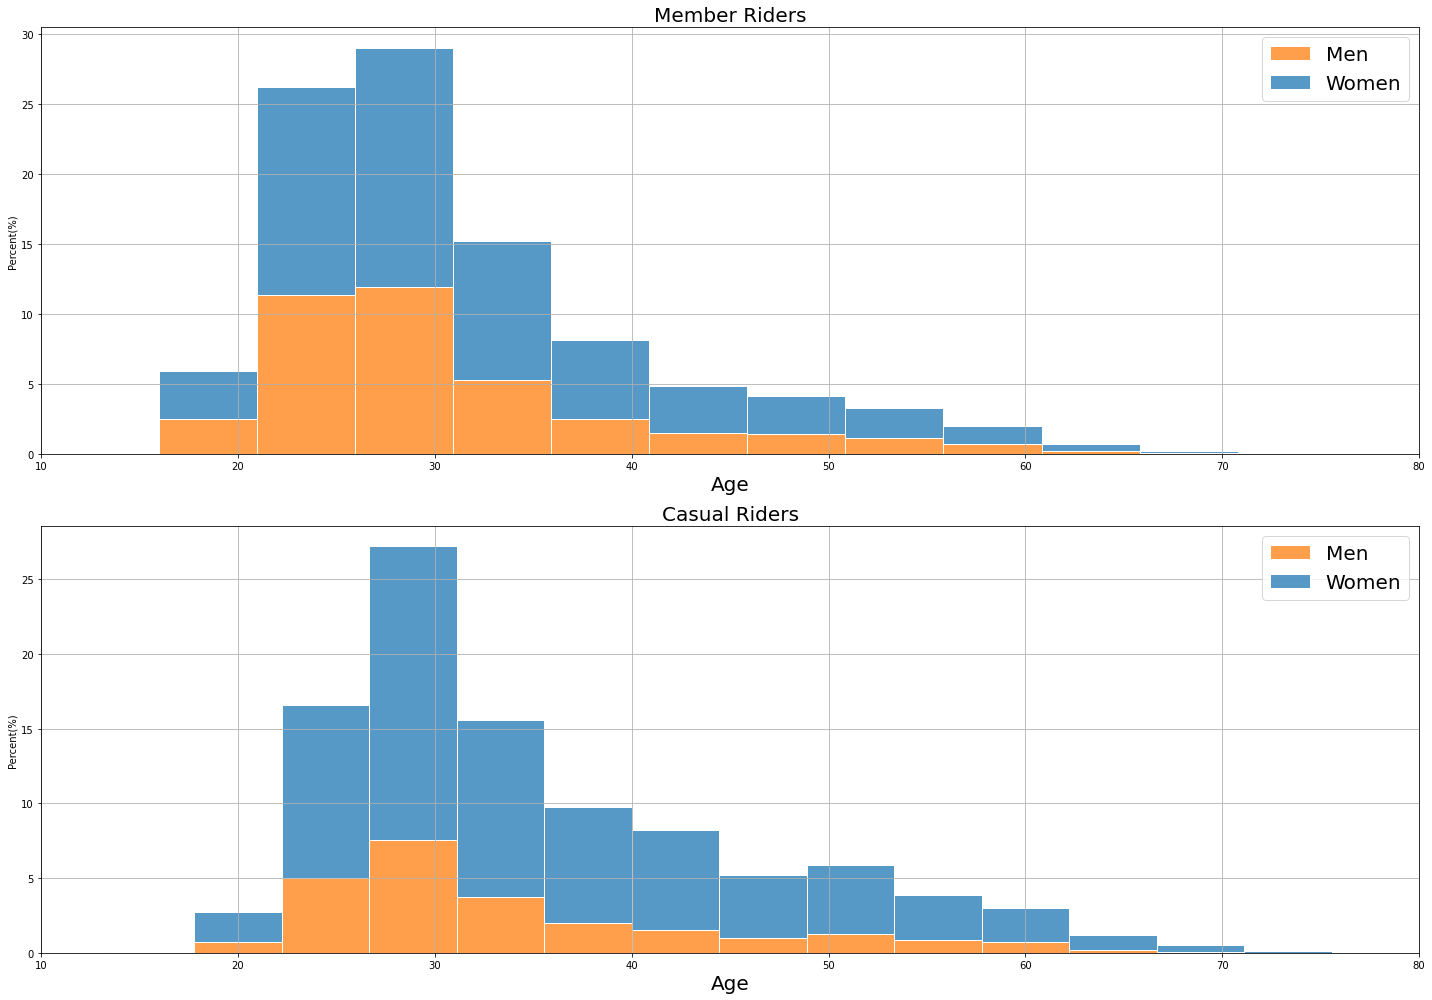

In [17]:
data_m.loc[:,'age'] = pd.DatetimeIndex(data_m['startdate']).year-data_m['birthday_year']
data_c.loc[:,'age'] = pd.DatetimeIndex(data_c['startdate']).year-data_c['birthday_year']
w = 5
n_m = math.ceil((((data_m['age']).max())-((data_m['age']).min()))/w)
n_c = math.ceil((((data_c['age']).max())-((data_c['age']).min()))/w)

plt.style.context('fivethirtyeight')
fig1, ax1 = plt.subplots(nrows=2,ncols=1, figsize=(20,14))

sns.histplot(data = data_m, x= 'age', ax = ax1[0], edgecolor='white',bins=n_m,\
             hue='gender',multiple="stack",stat = 'percent')

sns.histplot(data = data_c, x= 'age', ax = ax1[1], edgecolor='white',bins=n_c,\
             hue='gender',multiple="stack",stat = 'percent')

ax1[0].legend(['Men','Women'],fontsize=20)            
ax1[0].grid (axis='both')
ax1[0].set_xlabel('Age', fontsize = 20)
ax1[0].set_xlim([10, 80])
ax1[0].set_ylabel('Percent(%)')
ax1[0].set_title('Member Riders', fontsize=20)
ax1[1].set_xlabel('Age', fontsize = 20)
ax1[1].set_title('Casual Riders', fontsize=20)
ax1[1].legend(['Men','Women'],fontsize=20)
ax1[1].set_ylabel('Percent(%)')
ax1[1].grid (axis='both')
ax1[1].set_xlim([10, 80])
fig1.tight_layout()
plt.show()
# While memebrs usage is maximum during the weekends, causual riders use bikes more in weekdays 
# That can come from the fact that causual members use the cars more for commuting to the work while memebrs use bikes 
# for leisure

**Memebrs are slightly younger than causual riders**
* This observation again confirms our expectation, the members are younger and more prone to doing sport activitiies with bikes. Also, the results show that the number of female are less than men which suggests that the bike equipment (i.e, saddles) are not very appropriate for female. 

### Summary:
#### Observations:
  * Number of memebrs increase when pandemic started.
  * Memebrs are using bikes more on weekends while casual riders are riding more on weekdays.
  * Trip duration for members is taking longer than casual riders 
  * Common stations for members are cloes to Chicago attractions, cloes to Mishigan Lake, while casual riders use stations distributed across the city
  * Memebrs are slightly younger than casual riders.

#### Conclusion:
Memebrs are using bikes for leisure activities while casual riders are using bikes for commuting to work.